In [81]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
import pandas as pd
import numpy as np
from pathlib import Path
base_path = Path("/content/drive/MyDrive/data") # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

# Analiza i przetwarzanie danych na temat Titanica

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

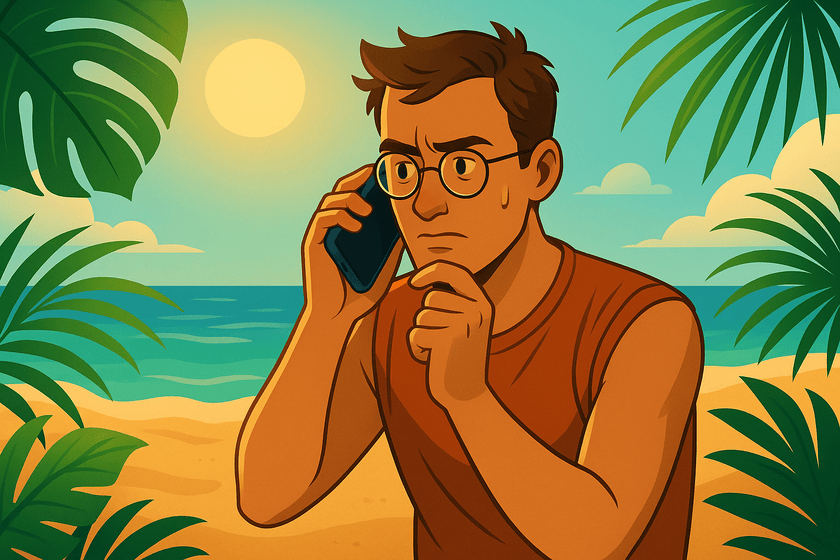

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [83]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

In [84]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
titanic_df.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,793.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,33.123938,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,51.578312,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.925000,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.500000,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN


Zacznijmy od przyporządkowania danym odpowiednich typów.

In [86]:
titanic_df.dtypes

,0
Survived,int64
Pclass,int64
Name,object
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object


In [87]:
titanic_df = titanic_df.convert_dtypes()
titanic_df.dtypes

,0
Survived,Int64
Pclass,Int64
Name,string[python]
Sex,string[python]
Age,Float64
SibSp,Int64
Parch,Int64
Ticket,string[python]
Fare,Float64
Cabin,string[python]


Następnie zajmijmy się brakującymi wartościami.

In [88]:

titanic_df.isna().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,98
Cabin,687


1. W cabin, danych kategorialnych, dodamy kategorię `unknown`, ponieważ nie będzie tam jednej najczęstszej wartości

Przy pozostałych kolumnach, spójrzmy na ich rozkład.

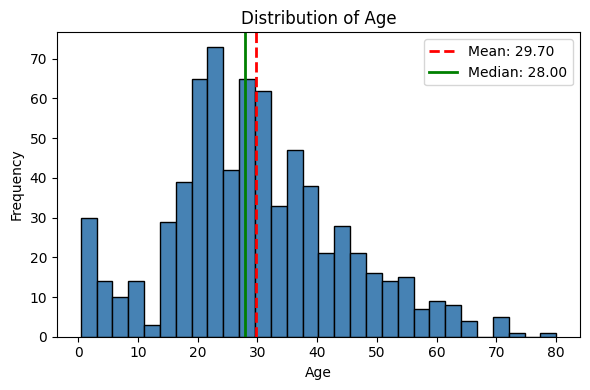

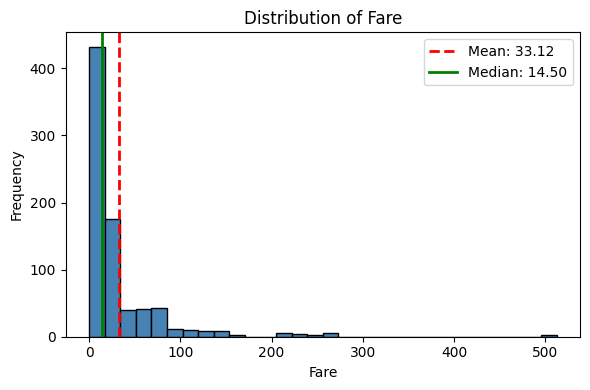

In [89]:
from matplotlib import pyplot as plt
def plot_numeric_histogram(df, column_name):
    """
    Plots a histogram for the specified column in the DataFrame,
    and adds vertical lines for the mean and median.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    Returns:
        None. Displays the histogram.
    """

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_numeric_histogram(titanic_df, 'Age')
plot_numeric_histogram(titanic_df, 'Fare')


Przy age mamy rozkład zblizony do normalnego -> wezmiemy srednia

Fare asymetryczny -> mediana

In [90]:
titanic_df.loc[titanic_df['Cabin'].isna(), 'Cabin'] = 'Unknown'
titanic_df.loc[titanic_df['Age'].isna(), 'Age'] = titanic_df['Age'].mean()
titanic_df.loc[titanic_df['Fare'].isna(), 'Fare'] = titanic_df['Fare'].median()

Spójrzmy jeszcze na rozkład Embarked

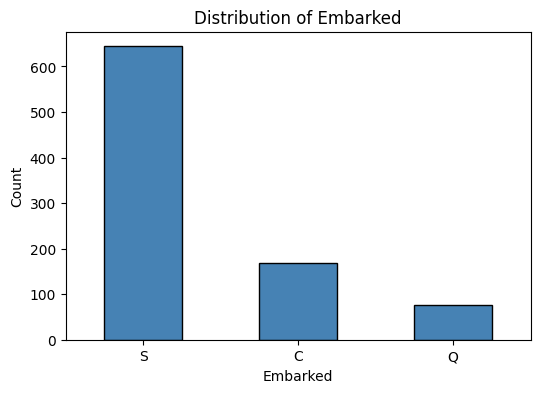

In [91]:
def plot_categorical_column(df, column_name):
    """
    Plots a bar chart for the specified categorical column.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """

    # count occurrences of each category
    counts = df[column_name].value_counts()

    plt.figure(figsize=(6, 4))
    counts.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()

plot_categorical_column(titanic_df, 'Embarked')

Ponieważ S znacząco przeważa, tak ustawimy te 2 brakujące wartości

In [92]:
titanic_df.loc[titanic_df['Embarked'].isna(), 'Embarked'] = 'S'

In [93]:
# Teraz nie powinno juz byc noneow
titanic_df.isna().sum()

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,0


Kolumny, które myślę, że warto dodać:
1. czy osoba jest dzieckiem
2. czy podróżowała z rodziną

In [94]:
titanic_df['Child'] = titanic_df['Age'] <= 18
titanic_df['Alone'] = (titanic_df['SibSp'] == 0) & (titanic_df['Parch'] == 0)

In [95]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Child,Alone
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,Unknown,S,False,False
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,False,False
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,Unknown,S,False,True
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S,False,False
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,Unknown,S,False,True


Teraz zakodujemy kategorie (Pclass jest już dobrze)

In [96]:
titanic_df['Sex'].unique()

<StringArray>
['male', 'female']
Length: 2, dtype: string

In [113]:
# Mamy 2 kategorie, zastosujemy binary encoding
titanic_df['Sex'] = titanic_df['Sex'].map({'male': 0, 'female': 1})

Przy Embarked, mamy tylko 4 wartosci, mozemy tu zrobic one hot encoding

In [99]:
titanic_df = titanic_df.join(pd.get_dummies(titanic_df['Embarked'], prefix='Embarked', ))
titanic_df = titanic_df.drop('Embarked', axis=1)

In [103]:
titanic_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Child,Alone,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,Unknown,False,False,False,False,True
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,False,False,True,False,False
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,Unknown,False,True,False,False,True
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,False,False,False,False,True
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,Unknown,False,True,False,False,True


In [116]:
titanic_df['Ticket'] = np.round(titanic_df['Ticket'].value_counts(normalize=True), 3)
titanic_df['Cabin'] = np.round(titanic_df['Cabin'].value_counts(normalize=True), 3)

Jeśli chodzi o kabinę i bilet, to mamy tam na tyle dużo wartości, że jedynym sensownym sposobem zakodowanie będzie frequency

Jeśli szukamy outlierow w danych liczbowych, mozemy uzyc box plota

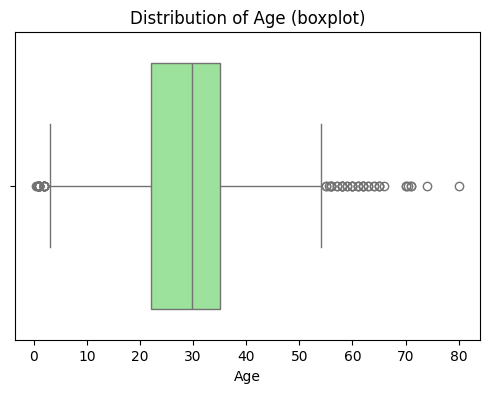

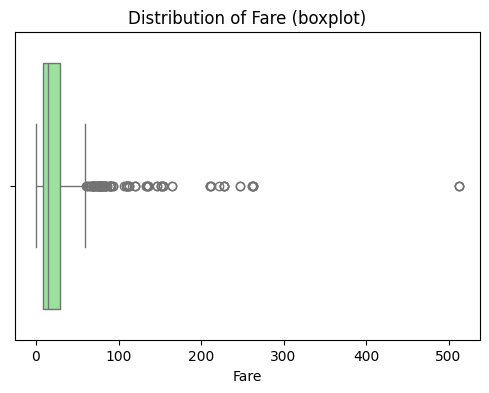

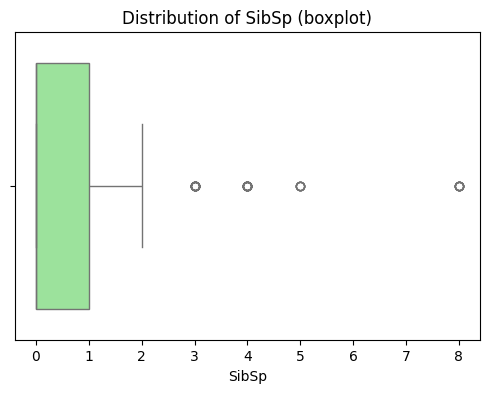

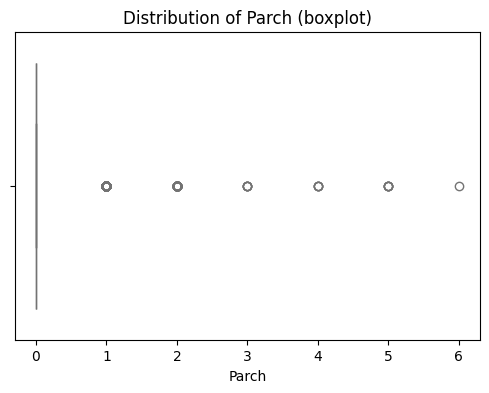

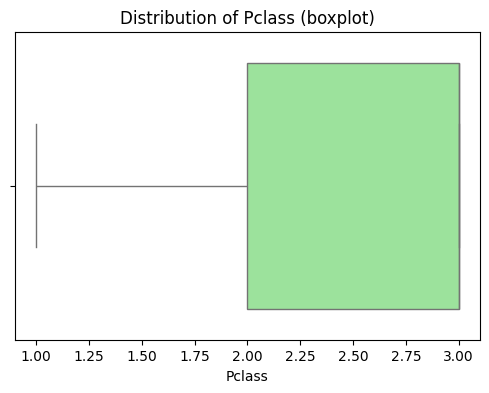

In [122]:
import seaborn as sns
def boxplot(df, column_name):
    """
    Displays a boxplot of the choosen column to show its distribution.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column_name].dropna(), color='lightgreen') # as you can see, you can use sns and plt at the same time
    plt.title(f'Distribution of {column_name} (boxplot)')
    plt.xlabel(column_name)

    plt.show()
boxplot(titanic_df, 'Age')
boxplot(titanic_df, 'Fare')
boxplot(titanic_df, 'SibSp')
boxplot(titanic_df, 'Parch')
boxplot(titanic_df, 'Pclass')

Wyraźnie widać outliera w Fare

Zostało jeszcze spojrzeć na kategorialne (name nie ma sensu,

SyntaxError: invalid syntax (ipython-input-4074922564.py, line 1)

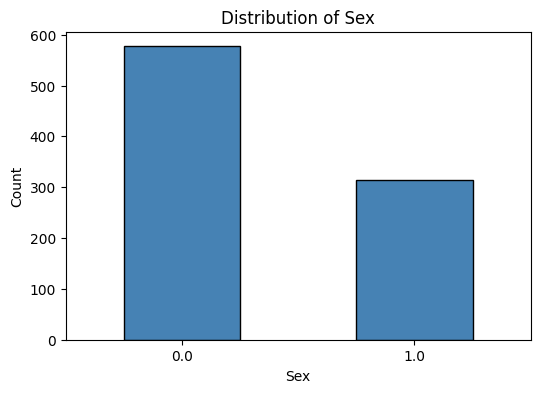

In [126]:
plot_categorical_column(titanic_df, 'Sex')

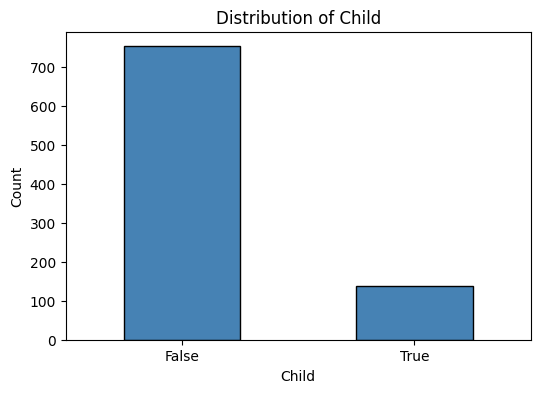

In [127]:
plot_categorical_column(titanic_df, 'Child')

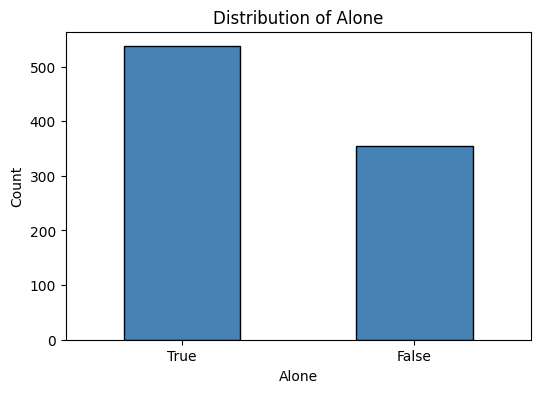

In [128]:
plot_categorical_column(titanic_df, 'Alone')

W kategorialnych nie ma outlierów (nie licząc ticket i name, ale tam dane są raczej unikalne)